In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
experiment_folders = glob.glob("../experiment_output/multif0_nharms_experiment_*_harmonics/")
print(experiment_folders)

['../experiment_output/multif0_nharms_experiment_3_harmonics/', '../experiment_output/multif0_nharms_experiment_5_harmonics/', '../experiment_output/multif0_nharms_experiment_6_harmonics/', '../experiment_output/multif0_nharms_experiment_2_harmonics/', '../experiment_output/multif0_nharms_experiment_4_harmonics/', '../experiment_output/multif0_nharms_experiment_1_harmonics/']


In [9]:
def get_aggregate_df(dataset_fname):
    metrics = [
        'Precision', 'Recall','Accuracy', 'Substitution Error',
        'Miss Error', 'False Alarm Error', 'Total Error', 'Chroma Precision',
        'Chroma Recall', 'Chroma Accuracy', 'Chroma Substitution Error',
        'Chroma Miss Error', 'Chroma False Alarm Error', 'Chroma Total Error'
    ]

    scores_mean = {m: [] for m in metrics}
    scores_std = {m: [] for m in metrics}
    model_key = []
    data_frames = []

    for i in range(1, 7):
        folder = "../experiment_output/multif0_nharms_experiment_{}_harmonics".format(i)
        dataset_scores = os.path.join(folder, dataset_fname)
        if os.path.exists(dataset_scores):
            model_key.append(i)
            df = pd.read_csv(dataset_scores)
            for m in metrics:
                scores_mean[m].append(df.ix[1][m])
                scores_std[m].append(df.ix[2][m])
        else:
            print("{} does not exist".format(dataset_scores))
            model_key.append(folder)
            for m in metrics:
                scores_mean[m].append(0)
                scores_std[m].append(0)
    
    return scores_mean, scores_std, model_key

In [37]:
bach10_mean, bach10_std, bach10_models = get_aggregate_df("bach10_score_summary.csv")
mdb_mean, mdb_std, mdb_models = get_aggregate_df("mdb_test_score_summary.csv")
su_mean, su_std, su_models = get_aggregate_df("su_score_summary.csv")

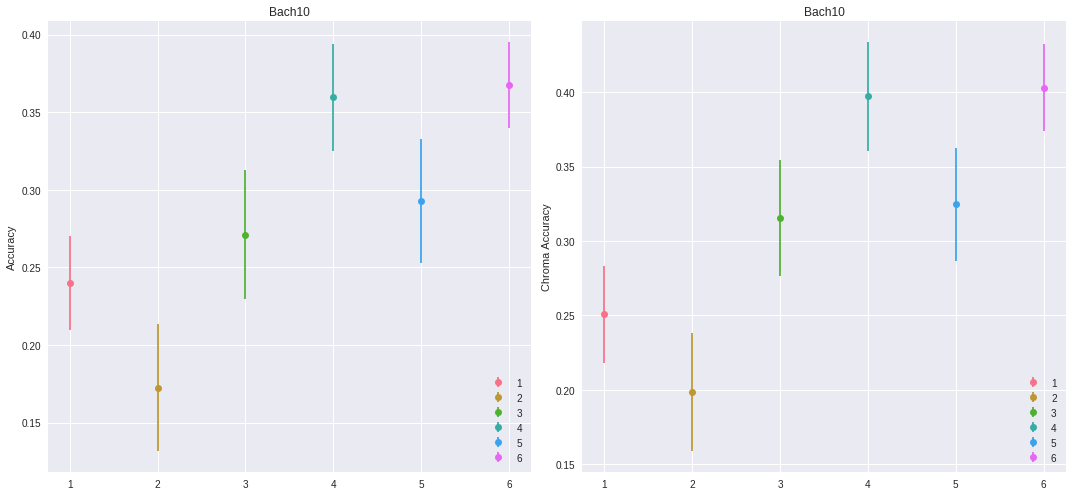

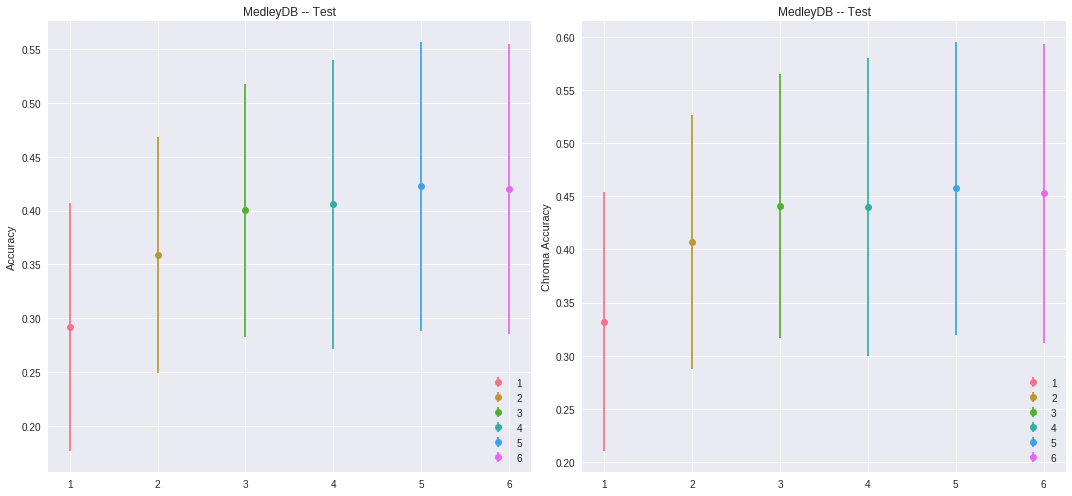

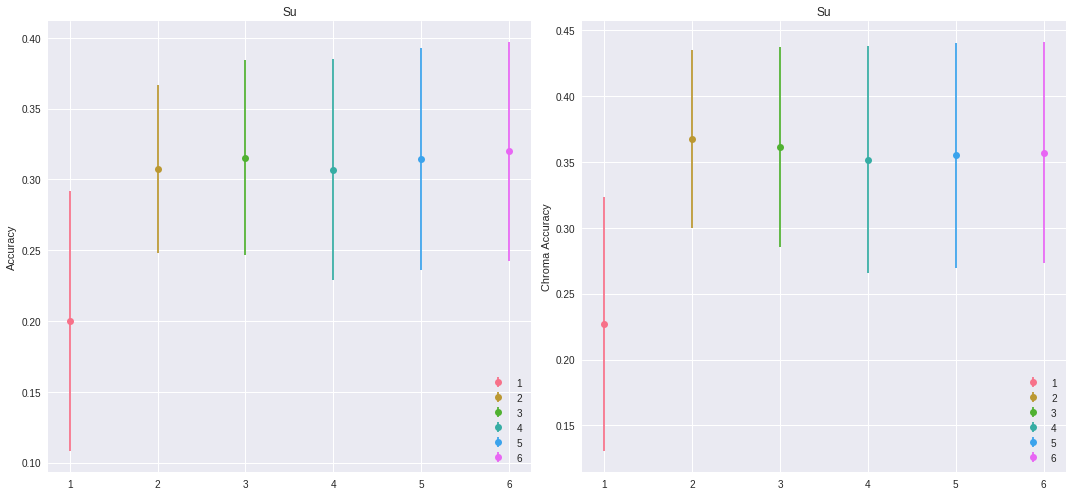

In [51]:
def plot_stuff(models, mean, std, m, title=None):
    tick_colors = sns.color_palette('husl', 6)
    x_labs = []
    fmt = 'o'
    for j, k in enumerate(models):
        color = tick_colors[j]
        plt.errorbar(j, mean[m][j], yerr=std[m][j], fmt=fmt, label=k, color=color)
        x_labs.append(k)

    plt.xticks(range(len(models)), x_labs)
    plt.ylabel(m)
    plt.legend(loc=4)
    plt.tight_layout()
    if title is not None:
        plt.title(title)

m1 = 'Accuracy'
m2 = 'Chroma Accuracy'


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot_stuff(bach10_models, bach10_mean, bach10_std, m1, title='Bach10')
plt.subplot(1, 2, 2)
plot_stuff(bach10_models, bach10_mean, bach10_std, m2, title='Bach10')
plt.savefig("../paper-figs/nharms_comparison_Bach10.pdf", format='pdf')

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot_stuff(mdb_models, mdb_mean, mdb_std, m1, title="MedleyDB -- Test")
plt.subplot(1, 2, 2)
plot_stuff(mdb_models, mdb_mean, mdb_std, m2, title="MedleyDB -- Test")
plt.savefig("../paper-figs/nharms_comparison_mdbtest.pdf", format='pdf')


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot_stuff(su_models, su_mean, su_std, m1, title='Su')
plt.subplot(1, 2, 2)
plot_stuff(su_models, su_mean, su_std, m2, title='Su')
plt.savefig("../paper-figs/nharms_comparison_su.pdf", format='pdf')



In [12]:
cd ../deepsalience/

/scratch/rmb456/multif0/deepsalience


In [34]:
from multif0_nharms_experiment import model_def
import core
import evaluate
import mir_eval
import pandas

In [35]:
def score_multif0_on_test_set(test_set_name, model, save_path, thresh=0.5, n_harms=None):
    """score a model on all files in a named test set
    """

    # get files for this test set
    test_set_path = os.path.join(evaluate.test_path(), test_set_name)
    test_npy_files = glob.glob(os.path.join(test_set_path, '*.npy'))

    all_scores = []
    for npy_file in sorted(test_npy_files):
        # get input npy file and ground truth label pair
        file_keys = os.path.basename(npy_file).split('.')[0].split('_')
        label_file = glob.glob(
            os.path.join(test_set_path, "{}.txt".format('_'.join(file_keys[:2])))
        )[0]

        # generate prediction on numpy file
        predicted_output, input_hcqt = \
            evaluate.get_single_test_prediction(model, npy_file=npy_file, n_harms=n_harms)

        # save prediction
        np.save(
            os.path.join(
                save_path,
                "{}_{}_prediction.npy".format(file_keys[0], file_keys[1])
            ),
            predicted_output.astype(np.float32)
        )

        # get multif0 output from prediction
        est_times, est_freqs = evaluate.pitch_activations_to_mf0(
            predicted_output, thresh
        )

        # save multif0 output
        evaluate.save_multif0_output(
            est_times, est_freqs,
            os.path.join(
                save_path,
                "{}_{}_prediction.txt".format(file_keys[0], file_keys[1])
            )
        )

        # load ground truth labels
        ref_times, ref_freqs = \
            mir_eval.io.load_ragged_time_series(label_file)

        # get multif0 metrics and append
        scores = mir_eval.multipitch.evaluate(
            ref_times, ref_freqs, est_times, est_freqs)
        scores['track'] = '_'.join(file_keys)
        all_scores.append(scores)

    # save scores to data frame
    scores_path = os.path.join(
        save_path, '{}_all_scores.csv'.format(test_set_name)
    )
    score_summary_path = os.path.join(
        save_path, "{}_score_summary.csv".format(test_set_name)
    )
    df = pandas.DataFrame(all_scores)
    df.to_csv(scores_path)
    df.describe().to_csv(score_summary_path)
    print(df.describe())

In [31]:
model = model_def(1)
model.compile(
        loss=core.bkld, metrics=['mse', core.soft_binary_accuracy],
        optimizer='adam'
)
model.load_weights(os.path.join(
    "../experiment_output/multif0_nharms_experiment_1_harmonics",
    "multif0_nharms_experiment_1_harmonics.pkl"
))

In [32]:
import json
with open("../experiment_output/multif0_nharms_experiment_1_harmonics/best_thresh.json") as fhandle:
    d = json.load(fhandle)
thresh = d['best_thresh']

In [36]:
save_path = '../experiment_output/multif0_nharms_experiment_1_harmonics/'
n_harms = 1
print("    > bach10...")
score_multif0_on_test_set(
    'bach10', model, save_path, thresh, n_harms=n_harms)
print("    > medleydb test...")
score_multif0_on_test_set(
    'mdb_test', model, save_path, thresh, n_harms=n_harms)
print("    > su...")
score_multif0_on_test_set(
    'su', model, save_path, thresh, n_harms=n_harms)

    > bach10...
       Precision     Recall   Accuracy  Substitution Error  Miss Error  \
count  10.000000  10.000000  10.000000           10.000000   10.000000   
mean    0.859790   0.249994   0.239914            0.026717    0.723288   
std     0.039152   0.033485   0.030412            0.013279    0.040536   
min     0.809469   0.196262   0.190235            0.007990    0.638938   
25%     0.839451   0.238669   0.228879            0.017286    0.712653   
50%     0.857031   0.250050   0.241557            0.027657    0.729165   
75%     0.872484   0.259242   0.252142            0.035043    0.740812   
max     0.936665   0.308947   0.288003            0.052115    0.786627   

       False Alarm Error  Total Error  Chroma Precision  Chroma Recall  \
count          10.000000    10.000000         10.000000      10.000000   
mean            0.014647     0.764652          0.890093       0.258994   
std             0.003711     0.031572          0.027610       0.035368   
min             0.008